# **Clustering: Part 1**

Ok in previous weeks, we used XGBoost and CatBoost to look into our data, and this did not yeild any fruit. So now, we are looking into K - means clustering to see if there is anything we can pull from the dataset. 

#### **Import Datasets and Packages**

In [3]:
# Standard Libraries
import os
import re
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from joblib import Memory
import warnings
from sklearn.exceptions import ConvergenceWarning

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns
import matplotlib.pyplot as plt

# SK Learn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA

# K means stuff
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
BDB_All_Plays_Model_Ready = pd.read_csv("../../Feature_Subsets/BDB_All_Plays_Model_Ready.csv")
PDA_Model_Ready = pd.read_csv("../../AFL_Final_Project/PDA_Model_Ready.csv") # Punt Data Analytics
FNF_Model_Ready = pd.read_csv("../../AFL_Final_Project/FNF_Model_Ready.csv") # First and Future

### **Big Data Bowl**

In order to get started here, first, I'm gonna re-visit PCA to cut down from the 100's of one hot variables to things we can actually visualize. 

In [ ]:
Xbdb = BDB_All_Plays_Model_Ready.drop(columns=['Inj_Occured'])
ybdb = BDB_All_Plays_Model_Ready['Inj_Occured']

PCA Transformer from Week 3

In [7]:
nuniques = Xbdb.nunique(dropna=True)     # change this here
numeric_cols = nuniques.index[nuniques > 2].tolist()
onehot_cols  = nuniques.index[nuniques == 2].tolist()

num_branch = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42))
])

pre = ColumnTransformer([
    ('num_pca', num_branch, numeric_cols),
    ('cat', 'passthrough', onehot_cols)
], remainder='drop')

Now let's run it for the Big Data Bowl 

In [8]:
pre.fit(Xbdb,ybdb)

pca = pre.named_transformers_['num_pca'].named_steps['pca']

print("Number of PCA components:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance:", pca.explained_variance_ratio_.cumsum())

Number of PCA components: 9
Explained variance ratio: [0.1717829  0.15000998 0.14061044 0.11333325 0.10831448 0.09639283
 0.07967639 0.07483798 0.06504175]
Cumulative variance: [0.1717829  0.32179288 0.46240332 0.57573657 0.68405105 0.78044388
 0.86012027 0.93495825 1.        ]


Cool and now, we'll grab the Transformed matrix: 

In [9]:
Xbdb_trans = pre.transform(Xbdb)

# Optional: build a nice DF
pca_cols = [f"PC{i+1}" for i in range(pca.n_components_)]
final_cols = pca_cols + onehot_cols
Xbdb_trans_df = pd.DataFrame(Xbdb_trans, columns=final_cols, index=Xbdb.index)

And now let's visualize them: 

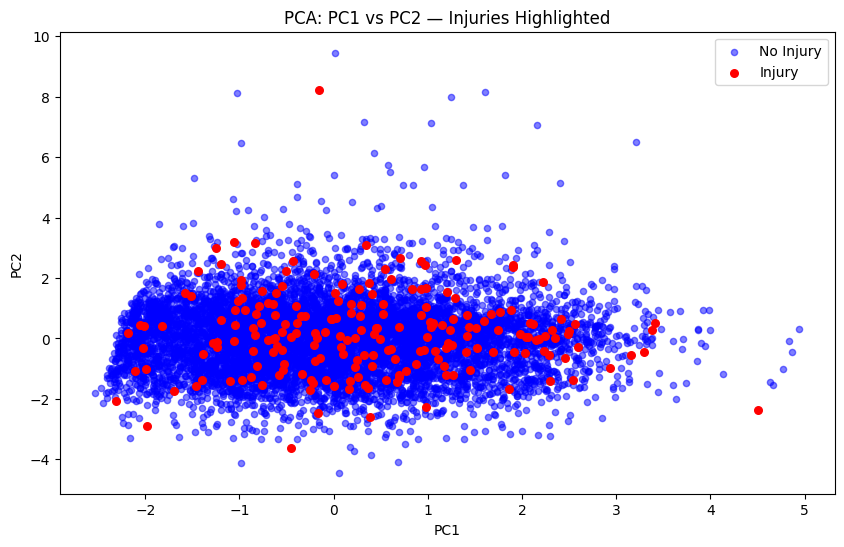

In [ ]:
plt.figure(figsize=(10,6))

# Non-injuries (0) → plotted first, faded in the background
plt.scatter(
    Xbdb_trans_df.loc[ybdb == 0, 'PC1'],
    Xbdb_trans_df.loc[ybdb == 0, 'PC2'],
    c='blue',
    alpha=0.5,
    s=20,
    label='No Injury'
)

# Injuries (1) → plotted second on top, in red, full opacity
plt.scatter(
    Xbdb_trans_df.loc[ybdb == 1, 'PC1'],
    Xbdb_trans_df.loc[ybdb == 1, 'PC2'],
    c='red',
    alpha=1.0,
    s=30,
    label='Injury'
)

plt.title("PCA: PC1 vs PC2 — Injuries Highlighted")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

And now we'll use K means

In [ ]:
# Use PCA-transformed data
X_pca = pre.transform(Xbdb)[:, :pca.n_components_]

# Try k = 2 to 10
results = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    results.append((k, sil))
    print(f"K={k}, Silhouette Score={sil:.4f}")

K=2, Silhouette Score=0.1296
K=3, Silhouette Score=0.1150
K=4, Silhouette Score=0.1225
K=5, Silhouette Score=0.1242
K=6, Silhouette Score=0.1314
K=7, Silhouette Score=0.1365
K=8, Silhouette Score=0.1269
K=9, Silhouette Score=0.1247
K=10, Silhouette Score=0.1275


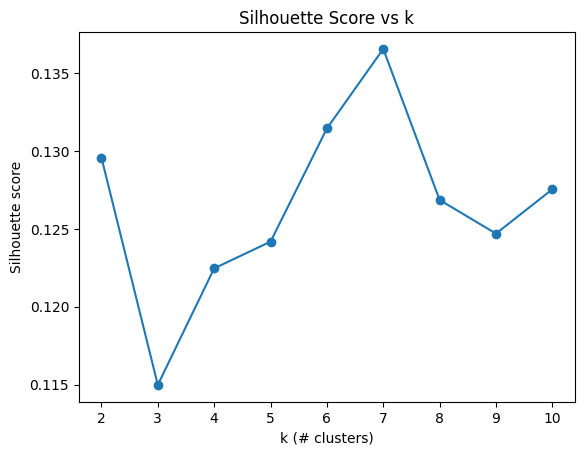

In [21]:
ks = [r[0] for r in results]
sil_scores = [r[1] for r in results]

plt.plot(ks, sil_scores, marker='o')
plt.xlabel("k (# clusters)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs k")
plt.show()

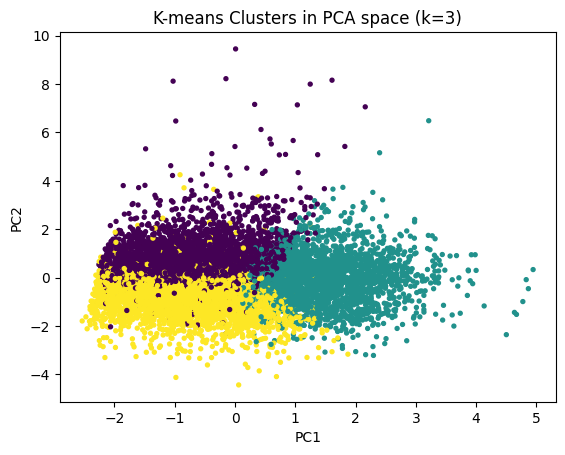

In [22]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=8)
plt.title("K-means Clusters in PCA space (k=3)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [23]:
inj = ybdb.values
table = pd.crosstab(cluster_labels, inj, rownames=['Cluster'], colnames=['Injury'])

print(table)
print("\nCluster injury proportions:")
print(table.div(table.sum(axis=1), axis=0))

Injury      0   1
Cluster          
0        3126  67
1        2508  85
2        2706  57

Cluster injury proportions:
Injury          0         1
Cluster                    
0        0.979017  0.020983
1        0.967219  0.032781
2        0.979370  0.020630


## **First and Future**

In [5]:
Xfnf = FNF_Model_Ready.drop(columns=['Inj_Occured'])
yfnf = FNF_Model_Ready['Inj_Occured']

In [6]:
nuniques = Xfnf.nunique(dropna=True)
numeric_cols = nuniques.index[nuniques > 2].tolist()
onehot_cols  = nuniques.index[nuniques == 2].tolist()

num_branch = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42))
])

pre = ColumnTransformer([
    ('num_pca', num_branch, numeric_cols),
    ('cat', 'passthrough', onehot_cols)
], remainder='drop')

Fit the PCA Transformer:

In [7]:
pre.fit(Xfnf, yfnf)

pca = pre.named_transformers_['num_pca'].named_steps['pca']

print("Number of PCA components:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance:", pca.explained_variance_ratio_.cumsum())

Xfnf_trans = pre.transform(Xfnf)

pca_cols  = [f"PC{i+1}" for i in range(pca.n_components_)]
final_cols = pca_cols + onehot_cols
Xfnf_trans_df = pd.DataFrame(Xfnf_trans, columns=final_cols, index=Xfnf.index)

Number of PCA components: 8
Explained variance ratio: [0.23081656 0.12518439 0.12213894 0.11474179 0.11114907 0.10005444
 0.0982411  0.09741654]
Cumulative variance: [0.23081656 0.35600095 0.47813989 0.59288168 0.70403075 0.80408518
 0.90232629 0.99974283]


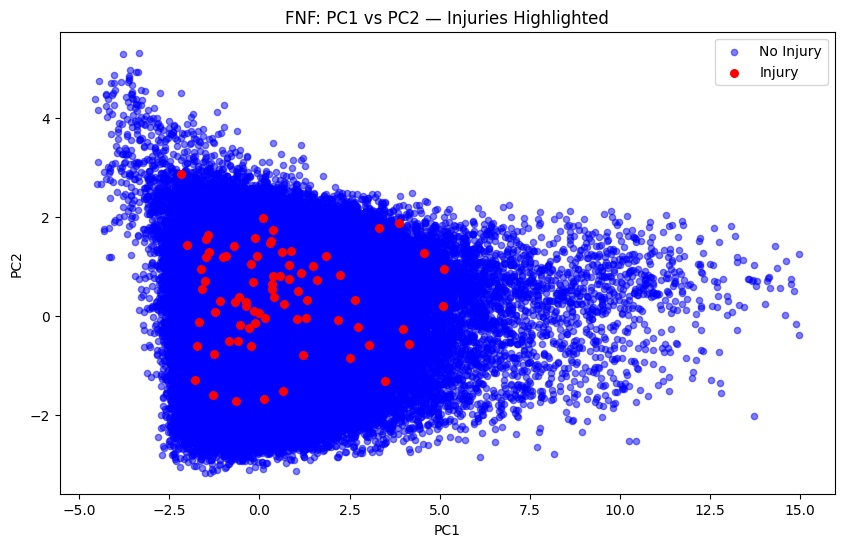

In [8]:
plt.figure(figsize=(10,6))

# Non-injuries (0) → plotted first, faded in the background
plt.scatter(
    Xfnf_trans_df.loc[yfnf == 0, 'PC1'],
    Xfnf_trans_df.loc[yfnf == 0, 'PC2'],
    c='blue',
    alpha=0.5,
    s=20,
    label='No Injury'
)

# Injuries (1) → plotted second on top, in red, full opacity
plt.scatter(
    Xfnf_trans_df.loc[yfnf == 1, 'PC1'],
    Xfnf_trans_df.loc[yfnf == 1, 'PC2'],
    c='red',
    alpha=1.0,
    s=30,
    label='Injury'
)

plt.title("FNF: PC1 vs PC2 — Injuries Highlighted")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

Ok so because the dataset of First and Future is so huge (272,000 rows) K means was really struggling, so we're going to downsample 

In [12]:
from sklearn.utils import resample

# Xfnf_pca is (267006, 8)
X_big = Xfnf_trans

# take e.g. 5,000 points for clustering diagnostics
X_small = resample(
    X_big,
    n_samples=5000,
    random_state=42
)

And now we'll use K means

In [13]:
print("Xfnf shape:", Xfnf.shape)
print("Xfnf_trans shape:", Xfnf_trans.shape)
print("Using PCA-only shape:", X_small.shape)

Xfnf shape: (267006, 47)
Xfnf_trans shape: (267006, 46)
Using PCA-only shape: (5000, 46)


In [14]:
# Use PCA-transformed data
Xfnf_pca = X_small[:, :pca.n_components_]

# Try k = 2 to 10
results = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(Xfnf_pca)
    sil = silhouette_score(Xfnf_pca, labels)
    results.append((k, sil))
    print(f"K={k}, Silhouette Score={sil:.4f}")

K=2, Silhouette Score=0.1555
K=3, Silhouette Score=0.1266
K=4, Silhouette Score=0.1125
K=5, Silhouette Score=0.1093
K=6, Silhouette Score=0.1048
K=7, Silhouette Score=0.1051
K=8, Silhouette Score=0.1090
K=9, Silhouette Score=0.1133
K=10, Silhouette Score=0.1084


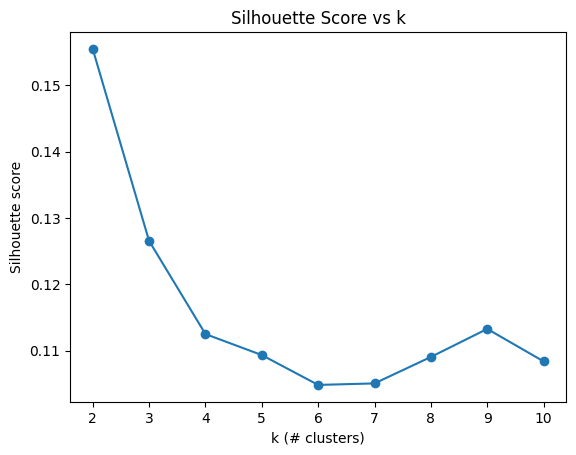

In [15]:
ks = [r[0] for r in results]
sil_scores = [r[1] for r in results]

plt.plot(ks, sil_scores, marker='o')
plt.xlabel("k (# clusters)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs k")
plt.show()

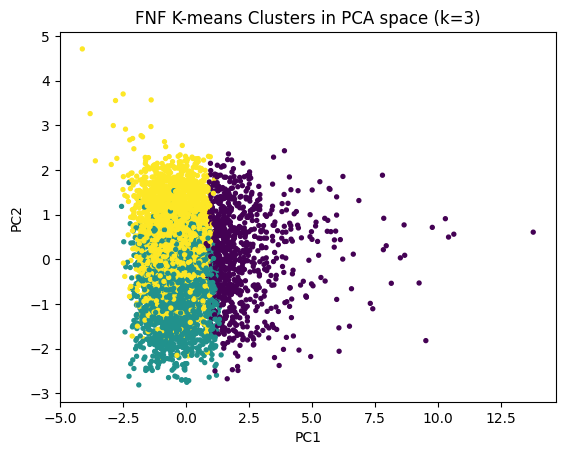

In [16]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(Xfnf_pca)

plt.scatter(Xfnf_pca[:, 0], Xfnf_pca[:, 1], c=cluster_labels, cmap='viridis', s=8)
plt.title("FNF K-means Clusters in PCA space (k=3)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## **Punt Data Analytics**

In [17]:
Xpda = PDA_Model_Ready.drop(columns=['Inj_Occured'])
ypda = PDA_Model_Ready['Inj_Occured']

In [18]:
nuniques = Xpda.nunique(dropna=True)
numeric_cols = nuniques.index[nuniques > 2].tolist()
onehot_cols  = nuniques.index[nuniques == 2].tolist()

num_branch = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42))
])

pre = ColumnTransformer([
    ('num_pca', num_branch, numeric_cols),
    ('cat', 'passthrough', onehot_cols)
], remainder='drop')

Fit the PCA Transformer:

In [21]:
pre.fit(Xpda, ypda)

pca = pre.named_transformers_['num_pca'].named_steps['pca']

print("Number of PCA components:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance:", pca.explained_variance_ratio_.cumsum())

Xpda_trans = pre.transform(Xpda)

pca_cols  = [f"PC{i+1}" for i in range(pca.n_components_)]
final_cols = pca_cols + onehot_cols
Xpda_trans_df = pd.DataFrame(Xpda_trans, columns=final_cols, index=Xpda.index)

Number of PCA components: 4
Explained variance ratio: [0.4347091  0.20336788 0.19921181 0.11626176]
Cumulative variance: [0.4347091  0.63807699 0.8372888  0.95355056]


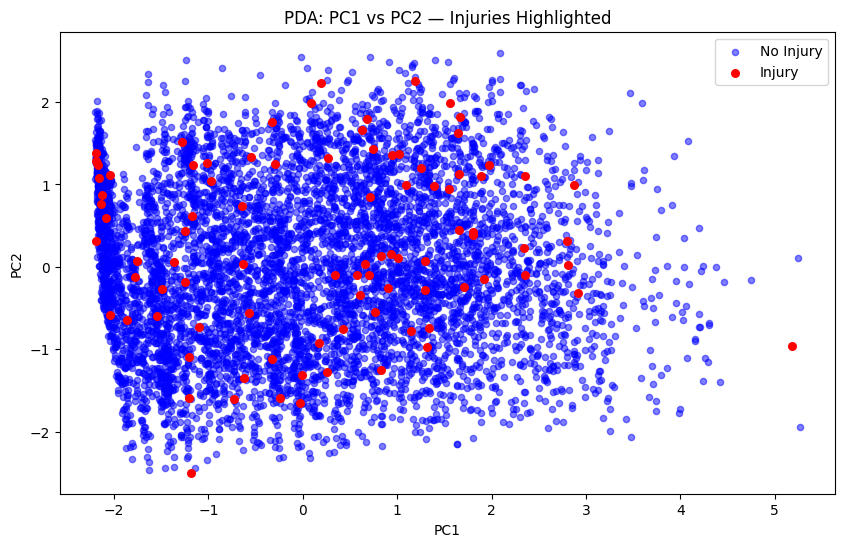

In [22]:
plt.figure(figsize=(10,6))

# Non-injuries (0) → plotted first, faded in the background
plt.scatter(
    Xpda_trans_df.loc[ypda == 0, 'PC1'],
    Xpda_trans_df.loc[ypda == 0, 'PC2'],
    c='blue',
    alpha=0.5,
    s=20,
    label='No Injury'
)

# Injuries (1) → plotted second on top, in red, full opacity
plt.scatter(
    Xpda_trans_df.loc[ypda == 1, 'PC1'],
    Xpda_trans_df.loc[ypda == 1, 'PC2'],
    c='red',
    alpha=1.0,
    s=30,
    label='Injury'
)

plt.title("PDA: PC1 vs PC2 — Injuries Highlighted")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [23]:
print("Xfnf shape:", Xpda.shape)
print("Xfnf_trans shape:", Xpda.shape)
print("Using PCA-only shape:", Xpda_trans.shape)

Xfnf shape: (6681, 68)
Xfnf_trans shape: (6681, 68)
Using PCA-only shape: (6681, 67)


In [25]:
# Use PCA-transformed data
Xpda_pca = pre.transform(Xpda)[:, :pca.n_components_]

# Try k = 2 to 10
results = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(Xpda_pca)
    sil = silhouette_score(Xpda_pca, labels)
    results.append((k, sil))
    print(f"K={k}, Silhouette Score={sil:.4f}")

K=2, Silhouette Score=0.2917
K=3, Silhouette Score=0.2296
K=4, Silhouette Score=0.2194
K=5, Silhouette Score=0.2191
K=6, Silhouette Score=0.2153
K=7, Silhouette Score=0.2192
K=8, Silhouette Score=0.2071
K=9, Silhouette Score=0.2082
K=10, Silhouette Score=0.2064


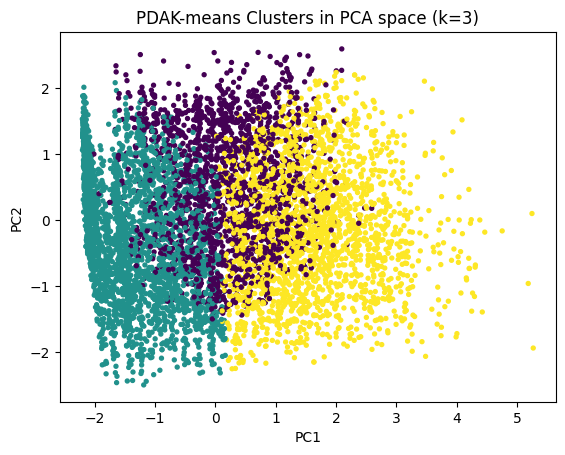

In [26]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(Xpda_pca)

plt.scatter(Xpda_pca[:, 0], Xpda_pca[:, 1], c=cluster_labels, cmap='viridis', s=8)
plt.title("PDAK-means Clusters in PCA space (k=3)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()